In [5]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


Dataset Overview:
              Age      Salary
count  100.000000  100.000000
mean    27.520000   74.994000
std      4.404956   16.871079
min     20.000000   36.600000
25%     24.000000   63.550000
50%     27.000000   75.750000
75%     31.000000   87.650000
max     35.000000  100.000000

Missing Values:
Age              0
Qualification    0
Salary           0
dtype: int64

Correlation Matrix:
             Age    Salary
Age     1.000000  0.767822
Salary  0.767822  1.000000


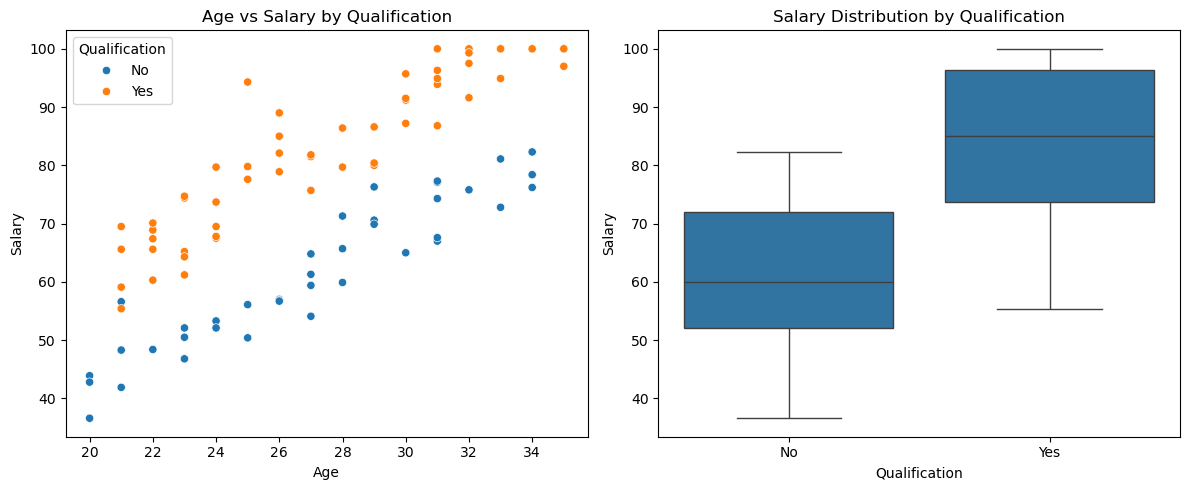


Model Evaluation:
Mean Squared Error: 29.34
Root Mean Squared Error: 5.42
R² Score: 0.91


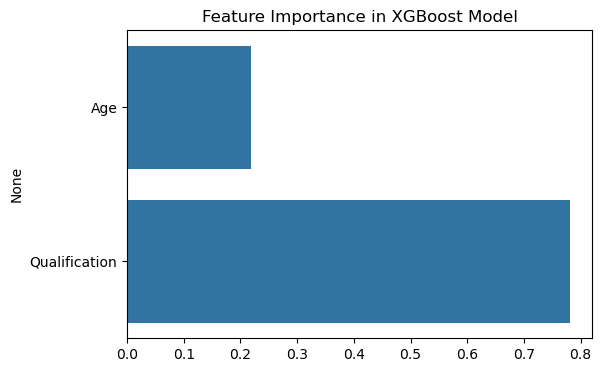


Sample Predictions vs Actual:
    Age Qualification  Actual_Salary  Predicted_Salary
83   27           Yes           81.8         79.835571
53   31           Yes          100.0         90.003197
70   21            No           41.9         49.123169
45   31           Yes           96.3         90.003197
44   31            No           67.0         72.500771


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create augmented dataset
np.random.seed(42)
n_samples = 100

# Generate Age (between 20 and 35)
ages = np.random.randint(20, 36, n_samples)

# Generate Qualification (60% Yes, 40% No)
qualifications = np.random.choice(['Yes', 'No'], size=n_samples, p=[0.6, 0.4])

# Generate Salary based on Age and Qualification
# Base salary: 40-60 for No qualification, 60-100 for Yes qualification
# Add linear trend with Age and some noise
salaries = []
for age, qual in zip(ages, qualifications):
    base_salary = 60 if qual == 'Yes' else 40
    salary = base_salary + (age - 20) * 3  # Linear increase with age
    noise = np.random.normal(0, 5)  # Add noise
    salary = max(30, min(100, salary + noise))  # Keep salary in 30-100 range
    salaries.append(round(salary, 1))

data = {
    'Age': ages,
    'Qualification': qualifications,
    'Salary': salaries
}
df = pd.DataFrame(data)

# Step 2: Data Analysis
print("Dataset Overview:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# Correlation analysis
print("\nCorrelation Matrix:")
print(df.select_dtypes(include=[np.number]).corr())

# Visualize relationships
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Age', y='Salary', hue='Qualification', data=df)
plt.title('Age vs Salary by Qualification')

plt.subplot(1, 2, 2)
sns.boxplot(x='Qualification', y='Salary', data=df)
plt.title('Salary Distribution by Qualification')
plt.tight_layout()
plt.show()

# Step 3: Data Preprocessing
# Encode categorical variable 'Qualification'
le = LabelEncoder()
df['Qualification'] = le.fit_transform(df['Qualification'])

# Define features (X) and target (y)
X = df[['Age', 'Qualification']]
y = df['Salary']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: XGBoost Model Development
# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Step 5: Model Evaluation
# Make predictions
y_pred = xgb_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Feature importance
feature_importance = xgb_model.feature_importances_
features = X.columns

plt.figure(figsize=(6, 4))
sns.barplot(x=feature_importance, y=features)
plt.title('Feature Importance in XGBoost Model')
plt.show()

# Step 6: Predictions on sample data
sample_data = X_test.head()
sample_pred = xgb_model.predict(sample_data)
print("\nSample Predictions vs Actual:")
sample_df = pd.DataFrame({
    'Age': sample_data['Age'],
    'Qualification': le.inverse_transform(sample_data['Qualification']),
    'Actual_Salary': y_test.head().values,
    'Predicted_Salary': sample_pred
})
print(sample_df)